In [10]:
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import random

from models import network
from utils.Dataset import DatasetLoader

In [3]:
model = network.build_model((448, 448, 3), 0.0005)
model.load_weights('./ckpt/yolo')
decoder = network.OutputDecoder(score_threshold=0.2)

In [4]:
inputs = model.input
out = decoder(model.output)
final_model = keras.models.Model(inputs, out)

In [5]:
test_path = glob('./dataset/VOCdevkit/VOC2012_test/JPEGImages/*')

In [83]:
def load_sample(path):
    img = tf.io.decode_jpeg(tf.io.read_file(path))
    img = tf.image.resize(img, (448, 448))
    sample = tf.expand_dims(img, axis=0) / 255.
    
    return sample, img.numpy().astype(np.uint8)

In [84]:
class_dict = {
    0: "aeroplane",
    1: "bicycle",
    2: "bird",
    3: "boat",
    4: "bottle",
    5: "bus",
    6: "car",
    7: "cat",
    8: "chair",
    9: "cow",
    10: "diningtable",
    11: "dog",
    12: "horse",
    13: "motorbike",
    14: "person",
    15: "pottedplant",
    16: "sheep",
    17: "sofa",
    18: "train",
    19: "tvmonitor"
}

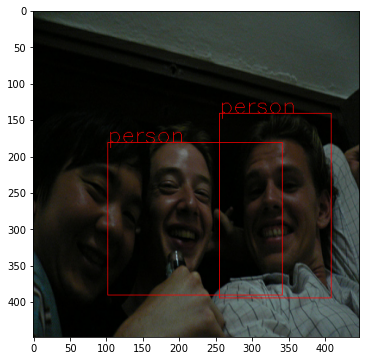

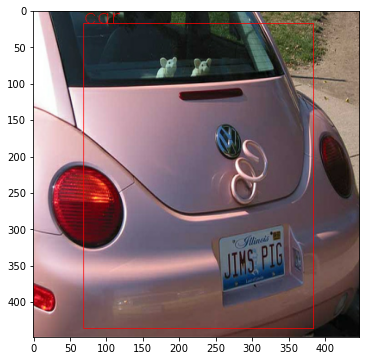

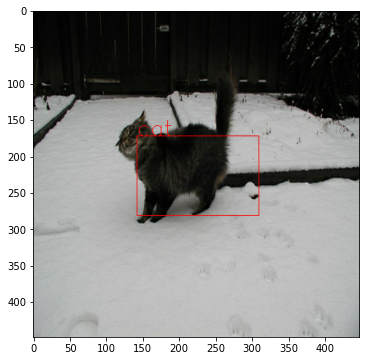

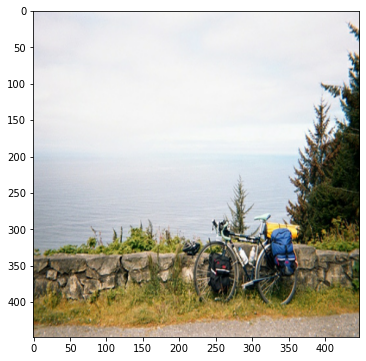

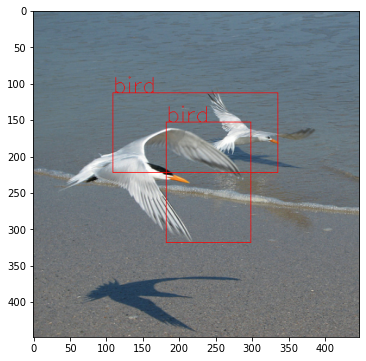

In [102]:
random.shuffle(test_path)
for path in test_path[:5]:
    plt.figure(figsize=(6, 6))
    sample, image = load_sample(path)
    valid_num, nms_boxes, nms_scores, nmsed_classes = final_model.predict(sample)
    for box, name in zip(nms_boxes[0][:valid_num[0]], nmsed_classes[0][:valid_num[0]]):
        pt1 = (int(box[1]), int(box[0]))
        pt2 = (int(box[3]), int(box[2]))
        image = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 1)
        image = cv2.putText(image, class_dict[name], pt1, color=(255, 0, 0), fontFace=cv2.FONT_ITALIC, fontScale=1)
        
    plt.imshow(image)
    plt.show()

In [15]:
train_ds, val_ds = DatasetLoader("./dataset/train_PASCAL2007.tfrecord", "./dataset/val_PASCAL2007.tfrecord", 448, 7, 20).get_dataset(4)

In [121]:
for i in val_ds.take(10):
    sample = i

In [122]:
# temp = np.zeros((4, 7, 7, 30))
# temp[..., :5] = sample[1][..., :5]
# temp[..., 10:] = sample[1][..., 5:]
valid_num, nms_boxes, nms_scores, nmsed_classes = final_model.predict(sample[0])
# valid_num, nms_boxes, nms_scores, nmsed_classes = decoder(temp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 [ 60.210648   -3.2107697 377.68927   444.78925  ] 0.0
1 [113.350006  42.483246 398.65     336.5225  ] 18.0
2 [118.97365   33.142197 414.72766  154.23482 ] 14.0
2 [190.426   179.4943  380.58157 274.50946] 14.0
2 [ 97.302376  84.870285 278.61307  227.7213  ] 14.0
2 [273.48993 249.42389 410.38135 355.51813] 8.0
2 [153.73306 267.68787 396.51846 401.0907 ] 14.0
3 [208.84546  106.178505 371.30524  332.5432  ] 17.0


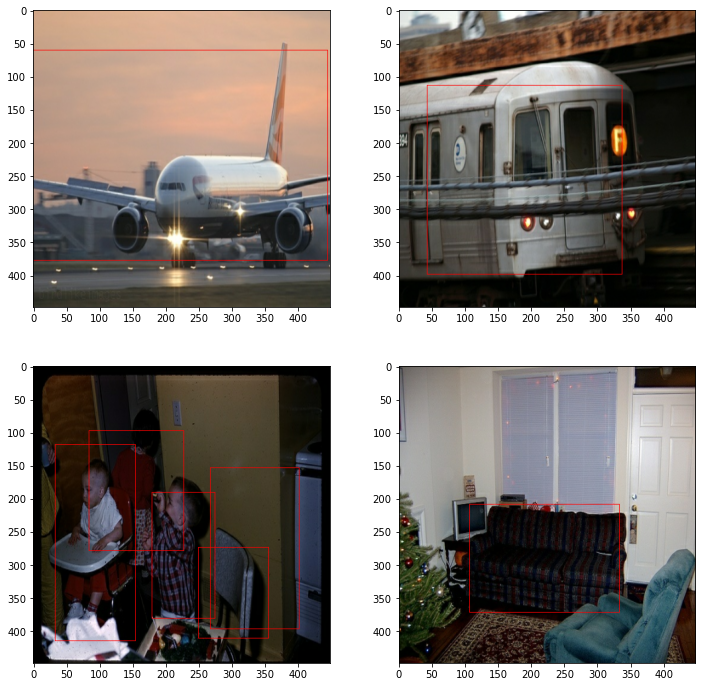

In [123]:
plt.figure(figsize=(12, 12))
for i in range(4):
    image = (sample[0][i].numpy())
    for box, name in zip(nms_boxes[i][:valid_num[i]], nmsed_classes[i][:valid_num[i]]):
        print(i, box, name)
        pt1 = (int(box[1]), int(box[0]))
        pt2 = (int(box[3]), int(box[2]))
        image = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 1)
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)

In [9]:
def convert_to_corner(points):
    return tf.concat(
        [points[..., :2] - points[..., 2:] / 2.0, points[..., :2] + points[..., 2:] / 2.0],
        axis=-1,
    )


# calculate intersection over union
# box = [x, y, w, h]
def calculate_iou(box1, box2):
    # box1_corner = convert_to_corner(box1)   # get corner point
    # box2_corner = convert_to_corner(box2)   # get corner point
    box1_corner = box1
    box2_corner = box2

    lu = tf.maximum(box1_corner[..., :2], box2_corner[..., :2])    # intersection left top
    rd = tf.minimum(box1_corner[..., 2:], box2_corner[...,  2:])    # intersection right down
    intersection = tf.maximum(tf.zeros_like(rd - lu), rd - lu)    # intersection width, height
    intersection_area = intersection[..., 0] * intersection[..., 1]

    box1_area = (box1[..., 2]) * (box1[..., 3])
    box2_area = (box2[..., 2]) * (box2[..., 3])
    union_area = tf.maximum(
        box1_area + box2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [10]:
calculate_iou(np.array([[ 22.028091, 31.774994, 436.49463,  408.85684 ]]), np.array([[ 80.97624,   55.319733, 395.42358,  253.23749 ]]))

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.28763738])>

In [14]:
pred = model.predict(sample[0])

In [17]:
pred = tf.maximum(pred, 0.)

In [18]:
pred

<tf.Tensor: shape=(4, 7, 7, 30), dtype=float32, numpy=
array([[[[2.59130359e-01, 4.17046726e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [4.44969028e-01, 4.49274033e-01, 0.00000000e+00, ...,
          2.30109934e-02, 5.30232117e-03, 0.00000000e+00],
         [4.16024625e-01, 4.65998054e-01, 0.00000000e+00, ...,
          5.19629717e-02, 4.07552756e-02, 3.75764742e-02],
         ...,
         [2.28893474e-01, 4.31553513e-01, 2.67167330e-01, ...,
          0.00000000e+00, 6.91767782e-03, 0.00000000e+00],
         [3.53686273e-01, 2.81826496e-01, 0.00000000e+00, ...,
          1.65519360e-02, 8.61729011e-02, 0.00000000e+00],
         [4.12305713e-01, 2.23204970e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 5.43905310e-02]],

        [[2.46708140e-01, 4.50518012e-01, 1.42439172e-01, ...,
          1.95668414e-02, 0.00000000e+00, 0.00000000e+00],
         [5.88258564e-01, 5.27590513e-01, 1.78045660e-01, ...,
          1.

In [19]:
def get_confidence(conf, class_):
    confidence_score = class_ * conf
    return confidence_score

In [20]:
classes = tf.maximum(pred[..., 10:], 0.)

cond = tf.equal(classes, tf.reduce_max(classes, axis=[-1])[..., None])
classes = tf.where(cond, classes, tf.zeros_like(classes))

score1 = tf.maximum(pred[..., 4, None], 0.)
score1 = tf.reshape(get_confidence(score1, classes), (-1, 7 * 7, 20))
score2 = tf.maximum(pred[..., 4 + 5, None], 0.)
score2 = tf.reshape(get_confidence(score2, classes), (-1, 7 * 7, 20))
scores = tf.concat([score1, score2], axis=1)

In [21]:
tf.maximum(pred[..., 10:], 0.)[2, 2, 3]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.291287  , 0.06961272, 0.04238602, 0.15547734, 0.        ,
       0.08040693, 0.03875218, 0.10712183, 0.01820216, 0.04222186,
       0.01753577, 0.        , 0.01277707, 0.00420435, 0.20101768,
       0.05769084, 0.04032804, 0.        , 0.        , 0.08441979],
      dtype=float32)>

In [22]:
cond[2, 2, 3]

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])>

In [17]:
np.where(pred[2][..., 4] == pred[2][..., 4].max())

(array([2], dtype=int64), array([3], dtype=int64))

In [18]:
pred[2, 2, 3, :5]

array([0.53538805, 0.32073617, 0.32756817, 0.1687731 , 0.08258592],
      dtype=float32)

In [14]:
pred[2, 2, 3, 5:10]

array([ 2.3487354e-02,  1.9540193e+00, -1.2047431e+00,  8.9990206e-02,
       -1.7011287e-03], dtype=float32)